In [1]:
import os
import pandas as pd
import numpy as np
import glob

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('custom_function')
import clustering

# Clustering results

In [6]:
raw_file_path = '../World_avg_results/Total/averaged_world_loocv_raw/*.csv'
raw_files = glob.glob(raw_file_path)
raw_data_dict = {}
for file in raw_files:
    region = file.split('\\')[1].split('.csv')[0]
    region = region.replace('HK(region)','HK')
    region = region.replace('South Africa','South_africa')
    
    raw_df = pd.read_csv(file,index_col=0)
    raw_data_dict[region] = raw_df

In [7]:
regions = ['USA','UK','South_africa','Australia','Germany','Japan',
            'CHN','HK','France','Chile','Mexico','Spain','Portugal',
            'Brazil','Israel','Russia','Egypt','Qatar','India']

relationships = pd.read_csv('../DataClean_FAVEE_HPP/input_data/RelDim_labels/159relationships_fix_label.csv',
                           index_col=0)
relationships = relationships['0'].to_list()

In [8]:
random_s = 4
for region in regions:
    dim_rel_scaled = raw_data_dict[region]
    dim_rel_scaled.index = relationships
    raw_results = clustering.create_cluster_models(data_type = "df",data = dim_rel_scaled,
                        methods=['KMeans'],ks=[3],keep_orig=True)
    raw_results.to_csv('../World_avg_results/Total/averaged_world_loocv_hpp/'+\
                      region+'_raw_3k.csv')
    print()
    print('{} 3 KMeans clusters in raw data:'.format(region))
    for n in range(len(raw_results['cl_k3'].unique())):
        each_cluster = raw_results.index[raw_results['cl_k3']==n]
        print("\nCluster "+str(n+1)+" Relationship:{}".format(len(each_cluster)))
        print(*raw_results.index[raw_results['cl_k3']==n], sep = ", ")
        
    print('***************************************************')


USA 3 KMeans clusters in raw data:

Cluster 1 Relationship:54
Parent and Child, Parent and Teenager, Wife and Husband, Fiance and Fiancee, Between Siblings, Between cousins, Between Close Friends, Between second cousins, Parent and Infant, Grandparent and Grandchild, Step-parent and Step-child, Foster-parent and Foster-child, Godparent and Godchild, Step-grandparent and Step-grandchild, Ancestor and Descendant, Bride and Groom, Man and His Mistress, Brother and Sister, Between step-siblings, Between close relatives, Between twins, Between a person and their family friends, Between a person and their deceased spouse, Between religious followers, Man and God, Between peers, Between classmates, Between roommates, Between sorority sisters, Between fraternity brothers, Bride and Bridesmaid, Groom and Groomsman, Between friends, Between Facebook Friends, Between childhood friends, Between pen-friends, Between romantic lovers, Between life-partners, Between soul-mates, Between church members

# Correlation of each region and averaged regions in each dimension(leave one out)

In [2]:
options (warn = -1)
library(openxlsx)
library(tidyverse)
library(reshape)
library(mgsub) # mapping

library(ggplot2)
library(ggpubr)
library(RColorBrewer)
library(corrplot)
library(corrr)

In [3]:
# Organize relationship score
regions = c(
    # English
    'USA','UK','Australia','South Africa',
    # Germany
    'Germany',
    # Japanese
    'Japan',
    # Hebrew
    'Israel',
    # Chinese
    'CHN','HK(region)',

    # French
    'France',
    # Spanish
    'Spain','Mexico','Chile',
    # Portuguese
    'Portugal','Brazil',
    # Russian
    'Russia',
    # Arabic
    'Egypt','Qatar',
    'India')

In [4]:
mapping = read.xlsx('output_data/categorical_model/categorical_results.xlsx',
                   sheet='raw33d_dissim')
# each region model
hostile_results = list()
private_results = list()
public_results = list()

for (region in regions){
    region = gsub('HK(region)','HK',region,fixed = TRUE)
    region = gsub('South Africa','South_africa',region)
    file_path = 'output_data/categorical_model/raw_dissim/'
    dissim_cluster_file = paste(region,'_raw_3k.csv',sep='')
    dissim_cluster_path = paste(file_path,dissim_cluster_file,sep='')
    region_model = read.csv(dissim_cluster_path,row.names=1)['cl_k3']
    region_model$'cluster' = mgsub(region_model$'cl_k3',
                                   mapping$'cluster_id',mapping[[region]])
    # relationships attributed to specific cluster in region x
    region_hostile = rownames(region_model[region_model$'cluster'=='Hostile',])
    region_private = rownames(region_model[region_model$'cluster'=='Private',])
    region_public = rownames(region_model[region_model$'cluster'=='Public',])
    
    region = gsub('HK','HK(region)',region,fixed = TRUE)
    region = gsub('South_africa','South Africa',region)
    hostile_results[[region]] = region_hostile
    private_results[[region]] = region_private
    public_results[[region]] = region_public
}

In [5]:
mapping = read.xlsx('output_data/categorical_model/categorical_results.xlsx',
                   sheet='averaged_world_loocv')
# each region model
hostile_loocv_results = list()
private_loocv_results = list()
public_loocv_results = list()

for (region in regions){
    region = gsub('HK(region)','HK',region,fixed = TRUE)
    region = gsub('South Africa','South_africa',region)
    file_path = '../World_avg_results/Total/averaged_world_loocv_hpp/'
    dissim_cluster_file = paste(region,'_raw_3k.csv',sep='')
    dissim_cluster_path = paste(file_path,dissim_cluster_file,sep='')
    region_model = read.csv(dissim_cluster_path,row.names=1)['cl_k3']
    region_model$'cluster' = mgsub(region_model$'cl_k3',
                                   mapping$'cluster_id',mapping[[region]])
    # relationships attributed to specific cluster in region x
    region_hostile = rownames(region_model[region_model$'cluster'=='Hostile',])
    region_private = rownames(region_model[region_model$'cluster'=='Private',])
    region_public = rownames(region_model[region_model$'cluster'=='Public',])
    
    region = gsub('HK','HK(region)',region,fixed = TRUE)
    region = gsub('South_africa','South Africa',region)
    hostile_loocv_results[[region]] = region_hostile
    private_loocv_results[[region]] = region_private
    public_loocv_results[[region]] = region_public
}

In [6]:
Jaccard_index = function(hostile_df,hostile_loocv_df){
    union_num = length(union(hostile_df,hostile_loocv_df))
    intersect_num = length(intersect(hostile_df,hostile_loocv_df))
    jaccard_index = intersect_num/union_num
    return(jaccard_index)
}

In [7]:
hpp_region_list = {}
for (region in regions){
    region_total_cor = matrix(nrow=3,ncol=3)
    colnames(region_total_cor) = paste(region,c('Hostile','Private','Public'),sep = '.')
    rownames(region_total_cor) = c('Hostile','Private','Public')
    
    # caculate Jaccard index between each region and the loocv results
    hostile_loocv_df = hostile_loocv_results[[region]]
    private_loocv_df = private_loocv_results[[region]]
    public_loocv_df = public_loocv_results[[region]]
    # column = region_hostile
    hostile_df = hostile_results[[region]]
    region_total_cor[1,1] = Jaccard_index(hostile_df,hostile_loocv_df)
    region_total_cor[2,1] = Jaccard_index(hostile_df,private_loocv_df)
    region_total_cor[3,1] = Jaccard_index(hostile_df,public_loocv_df)
    
    # column = region_private
    private_df = private_results[[region]]
    region_total_cor[1,2] = Jaccard_index(private_df,hostile_loocv_df)
    region_total_cor[2,2] = Jaccard_index(private_df,private_loocv_df)
    region_total_cor[3,2] = Jaccard_index(private_df,public_loocv_df)
    
    # column = region_public
    public_df = public_results[[region]]
    region_total_cor[1,3] = Jaccard_index(public_df,hostile_loocv_df)
    region_total_cor[2,3] = Jaccard_index(public_df,private_loocv_df)
    region_total_cor[3,3] = Jaccard_index(public_df,public_loocv_df)
    
    hpp_region_list[[region]] = region_total_cor
}

In [8]:
hpp_region_list[[region]]

,India.Hostile,India.Private,India.Public
Hostile,0.52727273,0.01351351,0.05882353
Private,0.07368421,0.63157895,0.09565217
Public,0.11428571,0.01886792,0.63953488


# Plot results

In [9]:
options (warn = -1) # remove warning
all_results_df = data.frame()
for (region in names(hpp_region_list)){
    region_df = hpp_region_list[[region]]
    # unify the labels in x axis
    colnames(region_df) = paste('Cluster',c(1,3,2),sep='')
    region_df = melt(region_df) 
    colnames(region_df) = c('total','region','value')
    
    region_df['region_label'] = region
    
    all_results_df = rbind(all_results_df,region_df)
}
all_results_df$region_label = factor(all_results_df$region_label,
levels = c('Australia','Brazil','CHN','Chile','France','Germany','HK(region)',
           'Israel','Japan','Mexico','Portugal',
           'South Africa','Spain','UK','USA',

           'Egypt','India','Qatar','Russia'
           ))
head(all_results_df,3)
all_results_df$'region' = factor(all_results_df$'region',
                                 levels=c('Cluster1','Cluster2','Cluster3'))

,total,region,value,region_label
,<fct>,<fct>,<dbl>,<fct>
1,Hostile,Cluster1,0.78571429,USA
2,Private,Cluster1,0.03333333,USA
3,Public,Cluster1,0.02857143,USA


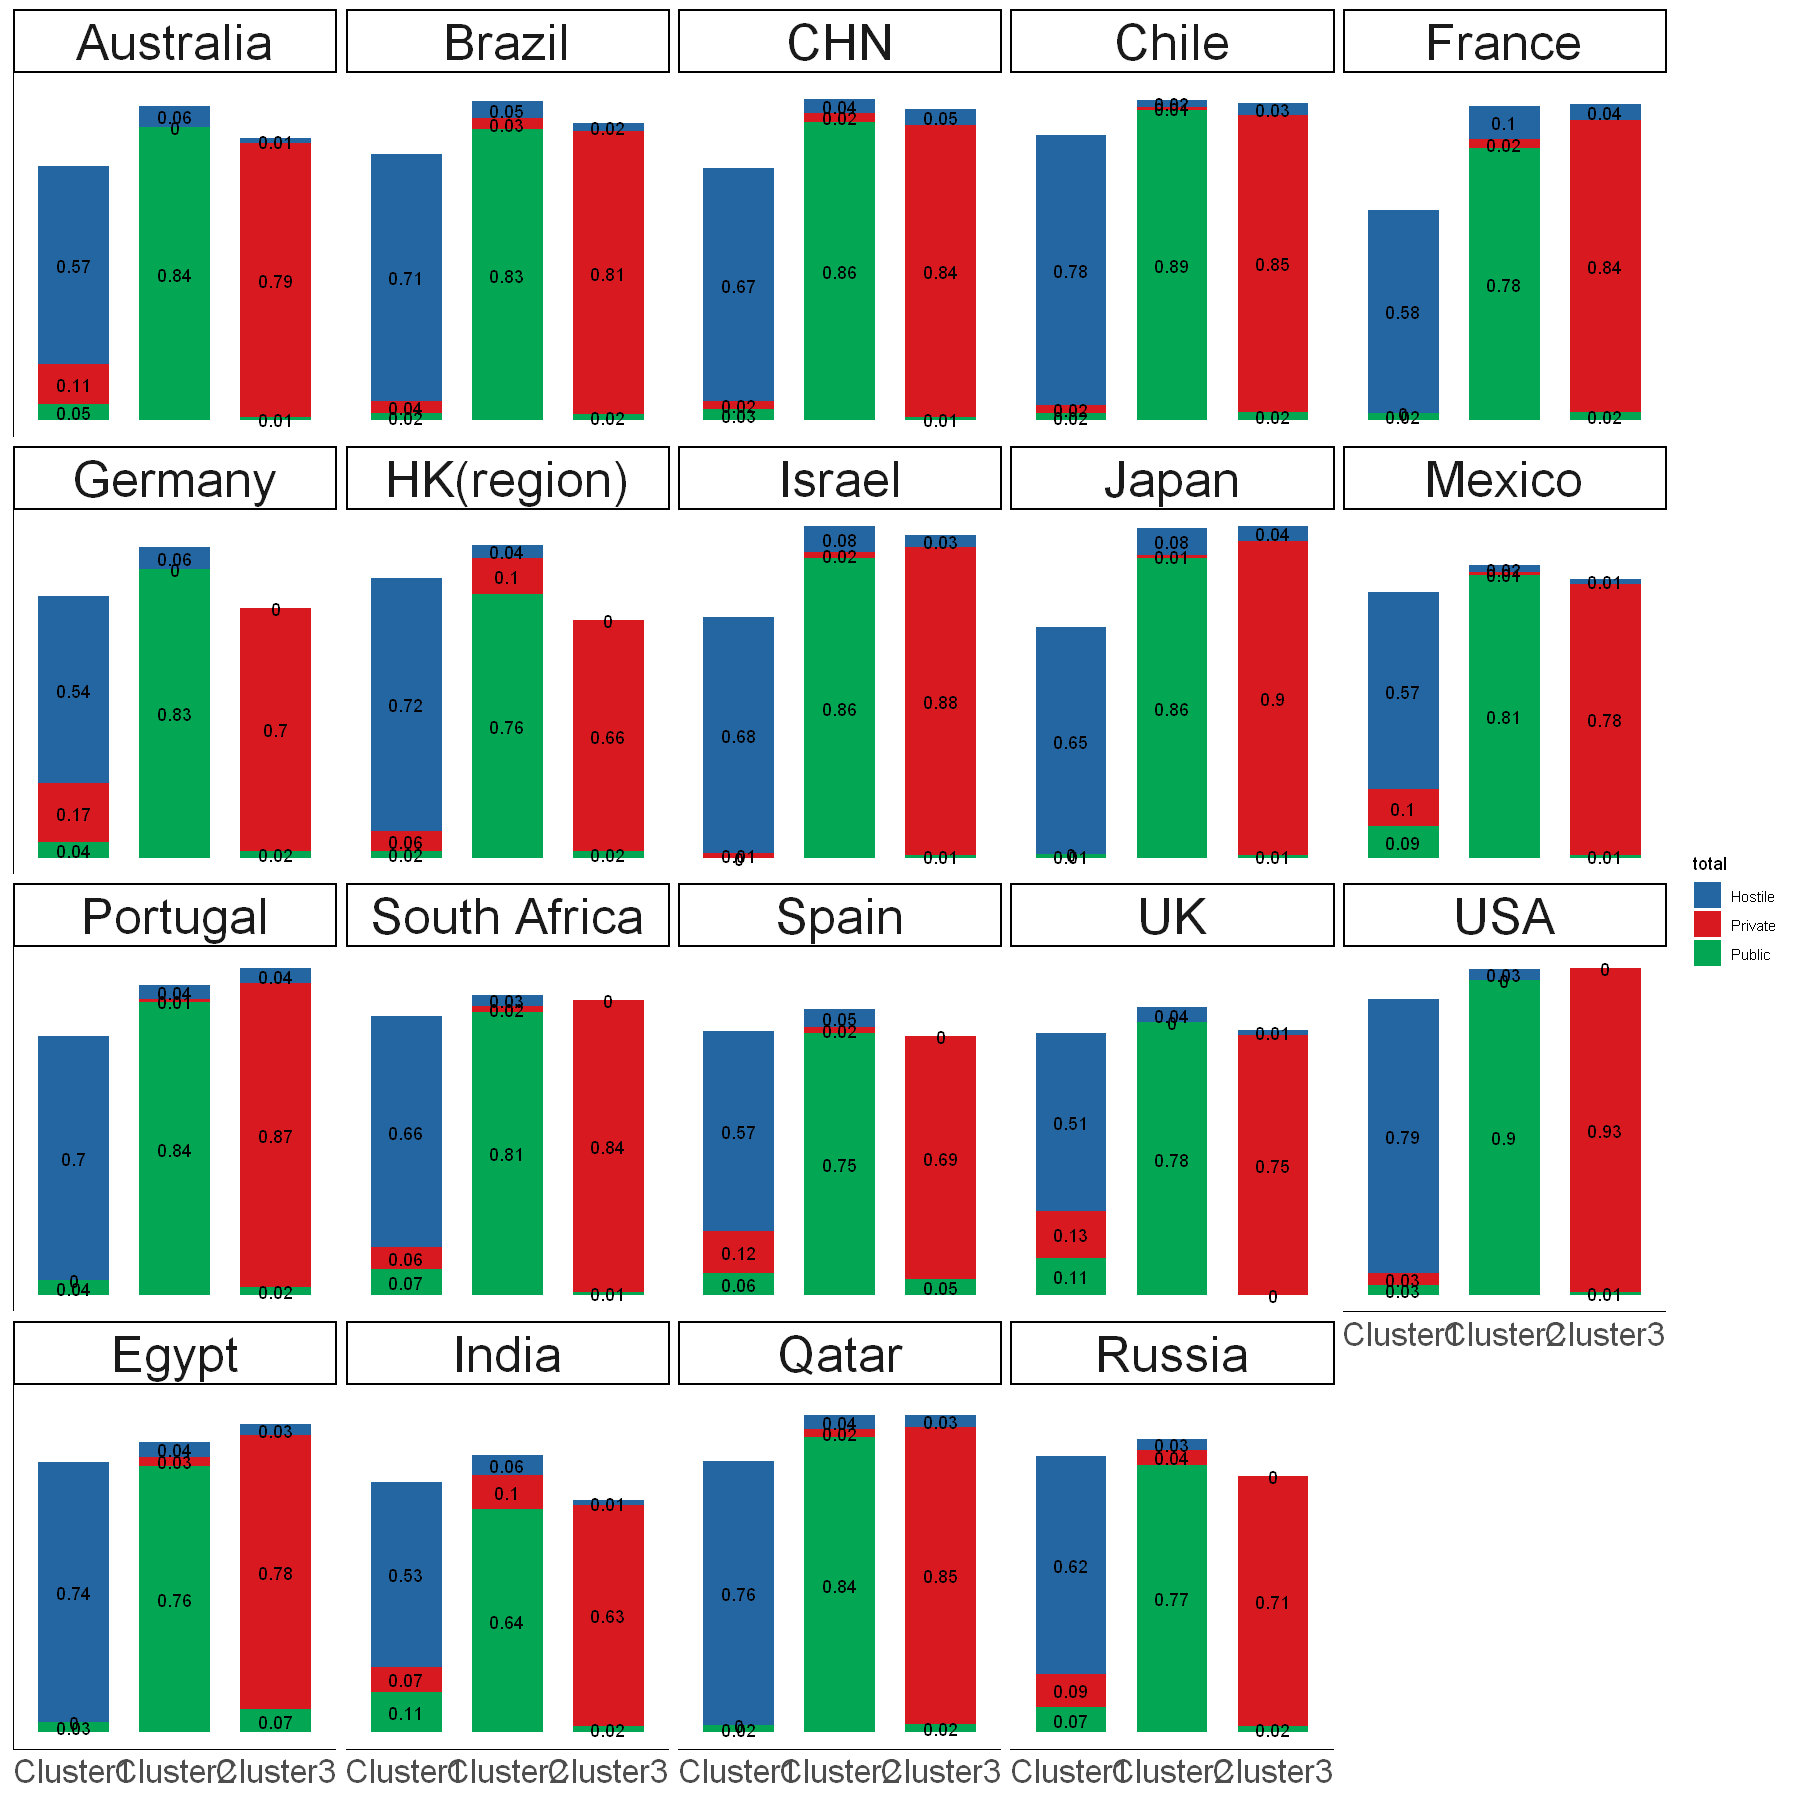

In [10]:
options(repr.plot.width=15,repr.plot.height=15)
all_results_df  %>%
ggplot(aes(x=region,y=abs(value),fill=total))+
geom_bar(stat='identity', width=0.7)+
facet_wrap(region_label~.,ncol=5)+
geom_text(aes(label=round(value,2)),position=position_stack(vjust=0.5))+
scale_fill_manual(values=c('Hostile'='#2466A2','Private'='#D81920','Public'='#03A652'))+
theme_classic()+
theme(#legend.position='none',
      axis.text.x = element_text(size=20),
      axis.text.y = element_blank(),axis.ticks = element_blank(),
      strip.text = element_text(size=30),
      axis.title = element_blank())

In [11]:
plot_line = function(regions){
    options(repr.plot.width=15,repr.plot.height=3.3)
    all_results_df %>% filter(region_label %in% regions) %>%
    ggplot(aes(x=region,y=abs(value),fill=total))+
    geom_bar(stat='identity', width=0.7)+
    facet_grid(.~region_label,switch = 'x')+
    geom_text(aes(label=round(value,2)),position=position_stack(vjust=0.5))+
    scale_fill_manual(values=c('Hostile'='#2466A2','Private'='#D81920','Public'='#C89626'))+
    theme_classic()+
    theme(legend.position='none',
          #axis.text.x = element_text(size=20),
          axis.line = element_line(colour = "white"),
          strip.background = element_rect(color='white',fill='#767171'),
          axis.text.x = element_blank(),
          axis.text.y = element_blank(),axis.ticks = element_blank(),
          strip.text = element_text(size=26,color='white'),
          axis.title = element_blank(),
          panel.spacing = unit(2,"lines"))
}
plot_last_line = function(regions){
    options(repr.plot.width=12,repr.plot.height=3.3)
    all_results_df %>% filter(region_label %in% regions) %>%
    ggplot(aes(x=region,y=abs(value),fill=total))+
    geom_bar(stat='identity', width=0.7)+
    facet_grid(.~region_label,switch = 'x')+
    geom_text(aes(label=round(value,2)),position=position_stack(vjust=0.5))+
    scale_fill_manual(values=c('Hostile'='#2466A2','Private'='#D81920','Public'='#C89626'))+
    theme_classic()+
    theme(legend.position='none',
          #axis.text.x = element_text(size=20),
          axis.line = element_line(colour = "white"),
          strip.background = element_rect(color='white',fill='#767171'),
          axis.text.x = element_blank(),
          axis.text.y = element_blank(),axis.ticks = element_blank(),
          strip.text = element_text(size=26,color='white'),
          axis.title = element_blank(),
          panel.spacing = unit(2,"lines"))
}

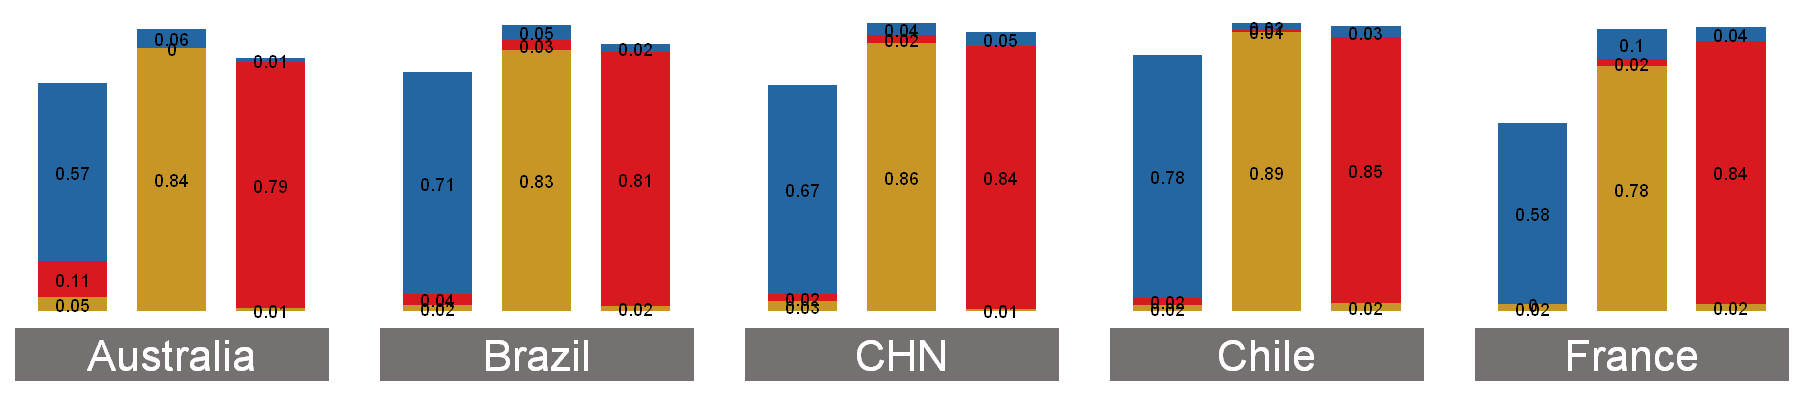

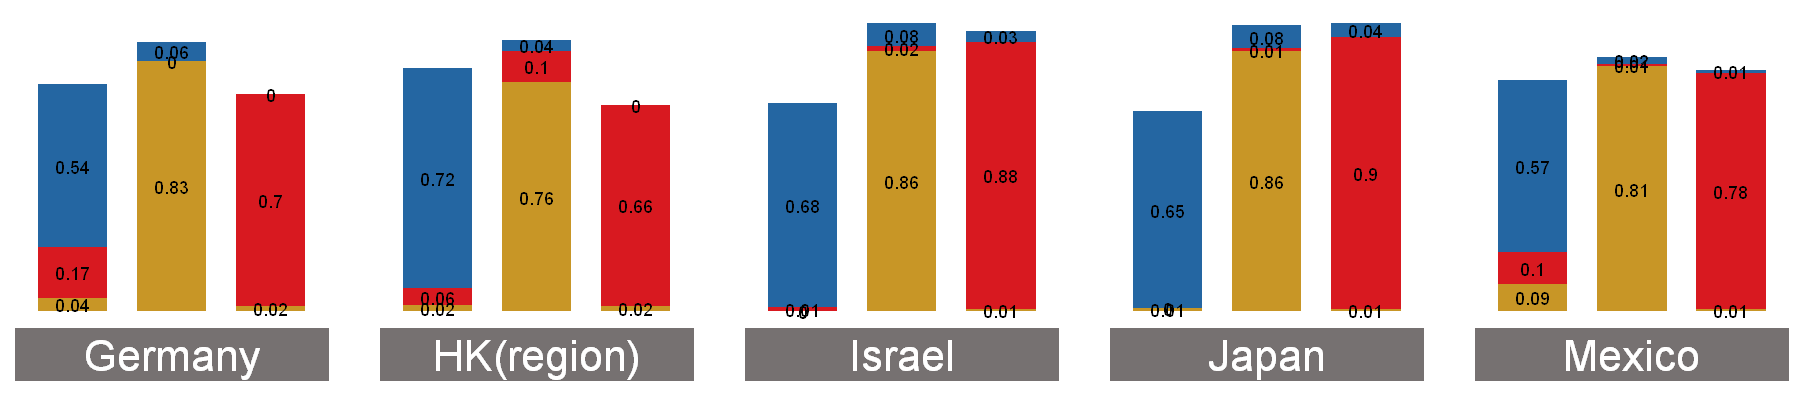

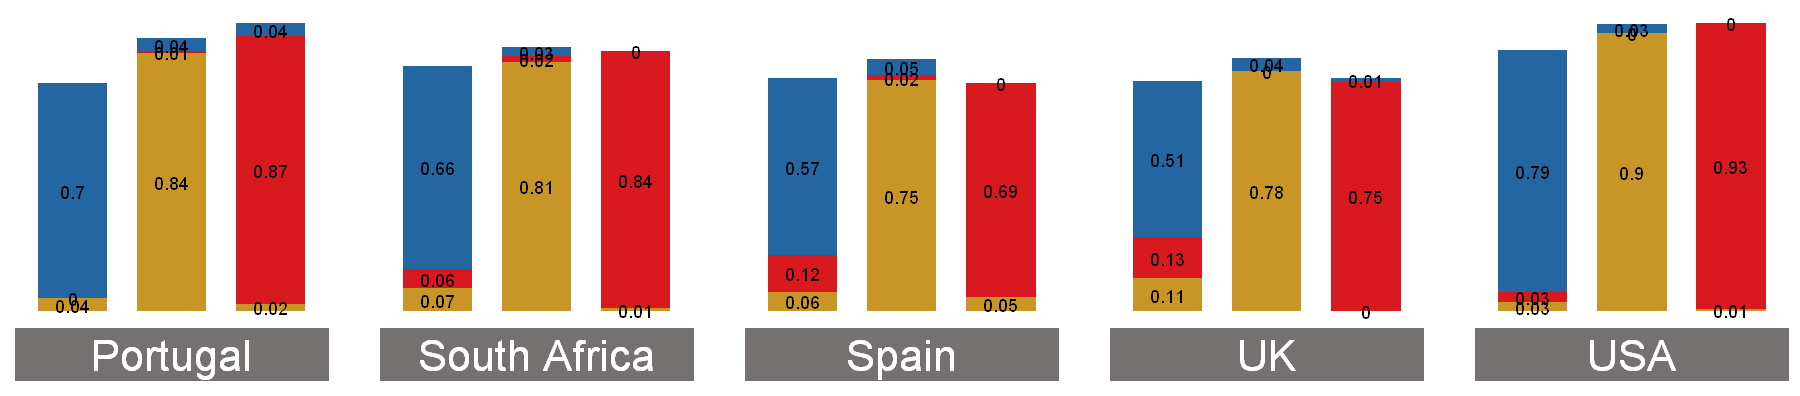

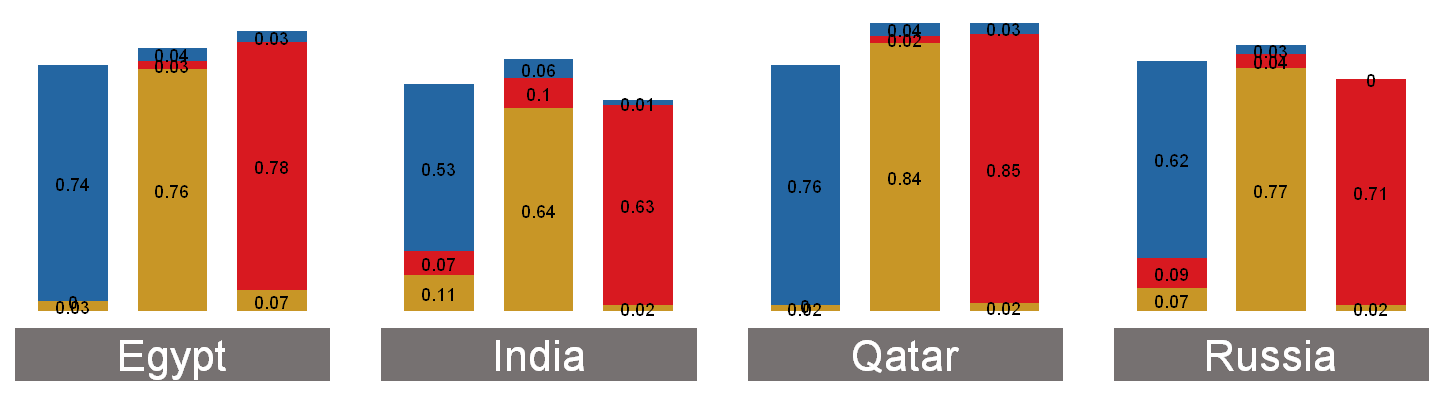

In [12]:
plot_line(c('Australia','Brazil','CHN','Chile','France'))
plot_line(c('Germany','HK(region)','Israel','Japan','Mexico'))
plot_line(c('Portugal','South Africa','Spain','UK','USA'))
plot_last_line(c('Egypt','India','Qatar','Russia'))

In [13]:
png("../output_graph/world_averaged/MeaningOf33D/hpp/1.png", bg="transparent",
    family = 'sans',units='in',width=15,height=3.3,res=300)
plot_line(c('Australia','Brazil','CHN','Chile','France'))
dev.off()

png("../output_graph/world_averaged/MeaningOf33D/hpp/2.png", bg="transparent",
    family = 'sans',units='in',width=15,height=3.3,res=300)
plot_line(c('Germany','HK(region)','Israel','Japan','Mexico'))
dev.off()

png("../output_graph/world_averaged/MeaningOf33D/hpp/3.png", bg="transparent",
    family = 'sans',units='in',width=15,height=3.3,res=300)
plot_line(c('Portugal','South Africa','Spain','UK','USA'))
dev.off()

png("../output_graph/world_averaged/MeaningOf33D/hpp/4.png", bg="transparent",
    family = 'sans',units='in',width=12,height=3.3,res=300)
plot_last_line(c('Egypt','India','Qatar','Russia'))
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2